In [9]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme('paper')

plt.rcParams['figure.figsize'] = [12, 7]
import matplotlib.font_manager as font_manager

font = font_manager.FontProperties(family='Helvetica',
                                          weight='bold',
                                          style='normal', size=16)

%matplotlib inline

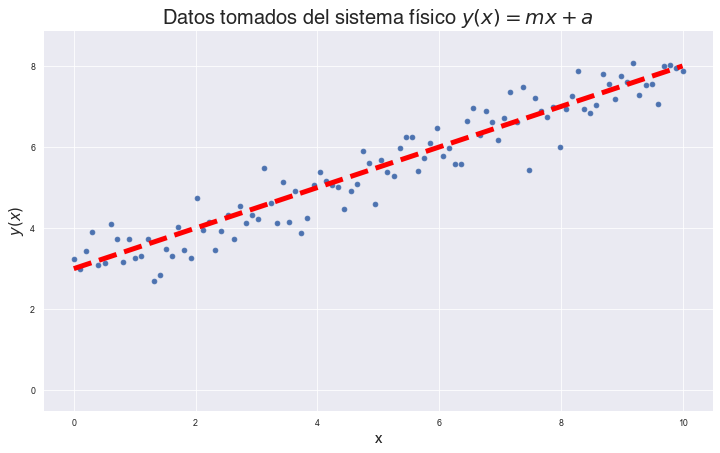

In [10]:
np.random.seed(42)

N = 100
x = np.linspace(0, 10, N)

M = 0.5
A = 3
S = 0.5
NOISE = np.random.randn(len(x)) 

MEAN_NOISE = np.mean(abs(NOISE) ** 2)

y = M * x + A + S * NOISE

fig = plt.figure(figsize=(12, 7))
plt.scatter(x, y)
plt.ylim(-0.5, np.max(y) + np.max(y) / 10)
plt.title(r'Datos tomados del sistema físico $y(x) = mx + a$', font='helvetica', 
            fontsize=20, fontstyle='italic')

plt.xlabel('x', font='helvetica', fontsize=15)
plt.ylabel(r'$y(x)$', font='helvetica', fontsize=15)

plt.plot([x[0], x[-1]], 
         [3, 8],linestyle='--', color='red', 
         lw=5)

plt.show()

# Funciones distribución de probabilidad

In [11]:
def Q(slope, origin, data, t):
    # función Q de los mínimos cuadrados

    teor = slope * t + origin
    diff = (teor - data) ** 2
    return diff

def slope_distribution(parameter, q, N, noise):
    # función de distribución de probabilidad de la pendiente
    
    # tomamos el logaritmo y le restamos el máximo para evitar overflow
    log = - q / (2 * noise ** 2) - (N+1) * np.log(noise)
    log_norm = log - np.max(log)
    
    # tamaño de los distintos rectángulos para luego normalizar
    d_i = (np.max(parameter) - np.min(parameter)) / (len(parameter) - 1)
    
    # tomamos la exponencial
    P = np.exp(log_norm) 
    
    # sumamos en los ejes del ruido y de la ordenada para obtener la distribución de la pendiente
    p_so = np.sum(P, axis=2)
    p_s = np.sum(p_so, axis=1)
    
    return p_s / np.sum(p_s * d_i)

def origin_distribution(parameter, q, N, noise):
    
    # igual que la distribución de la pendiente pero sumando en los ejes de la pendiente y el ruido
    log = - q / (2 * noise ** 2) - (N+1) * np.log(noise)
    log_norm = log - np.max(log)
    d_i = (np.max(parameter) - np.min(parameter)) / (len(parameter) - 1)
    P = np.exp(log_norm) 
    p_so = np.sum(P, axis=2)
    p_o = np.sum(p_so, axis=0)
    return p_o / np.sum(p_o * d_i)

def noise_distribution(parameter, q, N, noise):
    
    # igual que la distribución de la pendiente pero sumando en los ejes de la pendiente y la ordenada. 
    log = - q / (2 * noise ** 2) - (N+1) * np.log(noise)
    log_norm = log - np.max(log)
    d_i = (np.max(parameter) - np.min(parameter)) / (len(parameter) - 1)
    P = np.exp(log_norm)
    p_ns = np.sum(P, axis=0)
    p_n = np.sum(p_ns, axis=0)
    return p_n / np.sum(p_n * d_i)

In [12]:
K = 100
m = np.linspace(0, 1, K)
a = np.linspace(2, 4, K)
sigma = np.linspace(0.1, 2.0, K)

M_m, A_m, S_m = np.meshgrid(m, a, sigma)

# Actualización iterativa de la funcióm por mínimos cuadrados

In [13]:
RATIO = 100
T = N #len(y) // RATIO

q = np.zeros((T, K, K, K))
p_s = np.zeros((T, K))
p_a = np.zeros((T, K))
p_sigma = np.zeros((T, K))

new = 0
#for n, (y_n, x_n) in enumerate(zip(y, x)):
for n, (y_n, x_n) in enumerate(zip(y, x)):
    
    # y_n: dato real, x_n: "tiempo". Para estos valores probamos todos los valore propuestos de la 
    # pendiente y de la ordenada en el origen. 
    
    # aquí actualizamos la suma: Q_n = Q_{n-1} + (y_n - t_n) ** 2
    new += Q(M_m, A_m, y_n, x_n)
    q[n] = new

# Cálculo de las distribuciones de probabilidad

In [14]:
for n in range(len(q)):
    
    # para cada q_n, calculamos la distribución de probabilidad correspondiente utilizando las funciones
    # definidad arriba del todo. 
    p_s[n] = slope_distribution(m, q[n], n+1, S_m)
    p_a[n] = origin_distribution(a, q[n], n+1, S_m)
    p_sigma[n] = noise_distribution(sigma, q[n], n+1, S_m)

In [15]:
def plot(distribution, parameter, distribution_name, real_val):
    names = {'pendiente': 'Pendiente', 'origen': 'Origen', 'noise': 'Ruido'}
    
    if distribution_name not in names.keys():
        raise LookupError(f'{distribution_name} is not valid. Try one of {names.keys()}')
    
    N = 100
    lw = 10
    color = 'red'
    k = 5
    alpha = 0.0
    d_alpha = k / N
    title = (f'Distribución de probabilidad de la {names[distribution_name]}' 
             if distribution_name == 'pendiente'
             else f'Distribución de probabilidad del {names[distribution_name]}')

    fig = plt.figure(figsize=(12, 7))

    for n, p in enumerate(distribution[::k]):
        alpha += d_alpha
        if alpha > 1:
            alpha = 1

        if n == 5:
            label = 'Iteraciones anteriores'
        elif n == N // k - 1:
            lw=20
            color = 'blue'
            point = parameter[np.argmax(p)], np.max(p)
            label = 'Distribución final'
        else:
            label = None

        plt.scatter(parameter, p, c=color, s=lw, label=label, alpha=alpha)
    plt.axvline(x=real_val, linestyle='--', color='black', label=f'{names[distribution_name]} real')

    plt.scatter(point[0], point[1], edgecolor='black', s=150, c='green', 
                label=f'{names[distribution_name]} final')

    plt.title(title, font='helvetica', fontsize=20)
    plt.xlabel(f'{names[distribution_name]}', fontsize=15, font='helvetica', fontstyle='italic')
    
    plt.ylim(-0.1, np.max(p) + 0.2 * np.max(p))
    plt.legend(prop=font)
    plt.show()

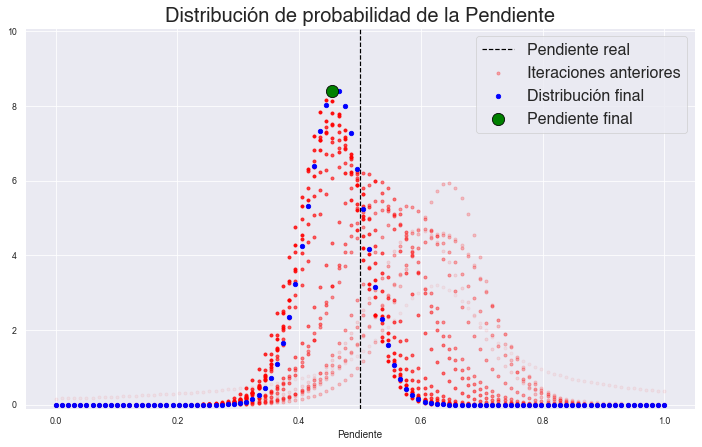

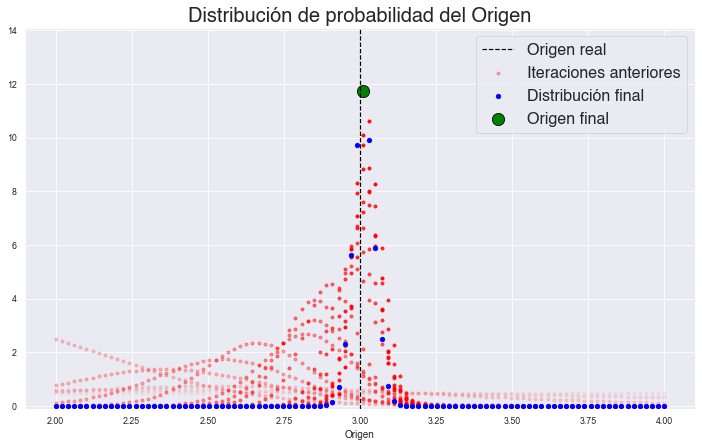

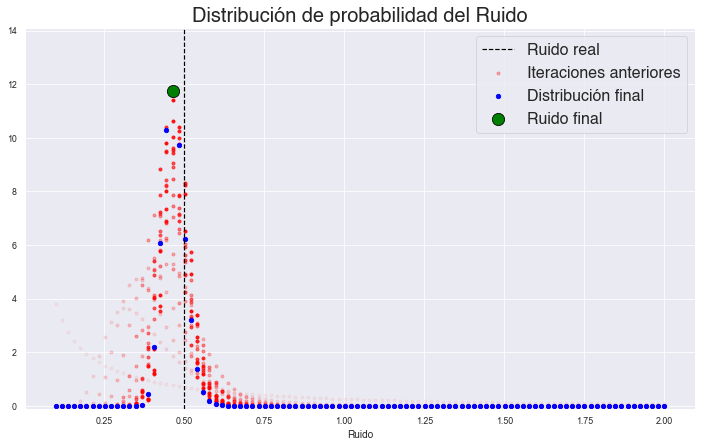

In [16]:
distributions = [p_s, p_a, p_sigma]
parameters = [m, a, sigma]
titles = ['pendiente', 'origen', 'noise']
valid_values = [M, A, S]

for distribution, parameter, title, valid_value in zip(distributions, parameters, titles, valid_values):
    plot(distribution, parameter, title, valid_value)

In [17]:
def statistical_info(distribution, parameter):
    d_param = (np.max(parameter) - np.min(parameter)) / (len(parameter) - 1)
    most_probable = parameter[np.argmax(distribution)]
    mean = np.sum(parameter * distribution * d_param)
    var = np.sum((parameter - mean) ** 2 * distribution * d_param)
    
    mean = np.round(mean, decimals=2)
    most_probable = np.round(most_probable, decimals=2)
    var = np.round(np.sqrt(var), decimals=2)
    
    return [most_probable, mean, var]

In [18]:
m_slope, mean_slope, var_slope = statistical_info(p_s[-1], m)
m_origin, mean_origin, var_origin = statistical_info(p_a[-1], a)
m_noise, mean_noise, var_noise = statistical_info(p_sigma[-1], sigma)

print(var_slope, var_origin, var_noise)

0.05 0.03 0.03


In [19]:
print(m_slope, m_origin, m_noise)

0.45 3.01 0.45


In [20]:
q_n = q[-1]
q_n.shape

(100, 100, 100)

In [21]:
log = - q / (2 * S_m ** 2) - (N+1) * np.log(S_m)
log_norm = log - np.max(log)

d_i = (np.max(parameter) - np.min(parameter)) / (len(parameter) - 1)


P = np.exp(log_norm) 

p_so = np.sum(P, axis=2)
last = p_so[-1]